In [22]:

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
from uav_active_sensing.config import PROCESSED_DATA_DIR
from uav_active_sensing.pytorch_dataloaders import TinyImageNetDataset
from uav_active_sensing.env import ImageEnv

import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.transforms.functional import resize

In [24]:
cifar10_processed_dir = PROCESSED_DATA_DIR / "cifar10"

cifar10_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar10_train_dataset = datasets.CIFAR10(
    root=cifar10_processed_dir, train=True, download=False, transform=cifar10_transform
)
cifar10_test_dataset = datasets.CIFAR10(
    root=cifar10_processed_dir, train=False, download=False, transform=cifar10_transform
)

cifar10_train_loader = DataLoader(cifar10_train_dataset, batch_size=1, shuffle=True)
cifar10_test_loader = DataLoader(cifar10_test_dataset, batch_size=1, shuffle=False)

In [25]:

TINY_IMAGENET_PROCESSED_DIR = PROCESSED_DATA_DIR / "tiny_imagenet/tiny-imagenet-200"

tiny_imagenet_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

tiny_imagenet_train_dataset = TinyImageNetDataset(
    root_dir=TINY_IMAGENET_PROCESSED_DIR, split="train", transform=tiny_imagenet_transform
)
tiny_imagenet_val_dataset = TinyImageNetDataset(
    root_dir=TINY_IMAGENET_PROCESSED_DIR, split="val", transform=tiny_imagenet_transform
)

tiny_imagenet_train_loader = DataLoader(tiny_imagenet_train_dataset, batch_size=1, shuffle=True)
tiny_imagenet_val_loader = DataLoader(tiny_imagenet_val_dataset, batch_size=1, shuffle=False)

In [26]:
# Class labels for CIFAR-10
classes = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# Function to visualize images from a batch


def visualize_batch(images, labels, classes, num_samples=1):
    plt.figure(figsize=(12, 5))
    for i in range(num_samples):
        plt.subplot(2, 5, i + 1)
        image = images[i].permute(1, 2, 0).numpy()
        plt.imshow(image)
        plt.title(classes[labels[i].item()])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

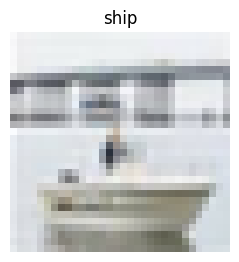

In [27]:
# Get a sample batch from the DataLoader
sample_batch = next(iter(cifar10_train_loader))
images, labels = sample_batch

# Visualize the first 10 images from the batch
visualize_batch(images, labels, classes, num_samples=1)

In [28]:
def visualize_tensors(tensor1, tensor2):
    """
    Visualizes two PyTorch tensors as images side by side.
    If tensors are 3D (e.g., RGB), they will be shown as color images.
    If tensors are 2D, they will be shown as grayscale images.

    Args:
        tensor1 (torch.Tensor): The first tensor to display.
        tensor2 (torch.Tensor): The second tensor to display.
    """
    # Ensure tensors are at least 2D
    if tensor1.dim() < 2 or tensor2.dim() < 2:
        raise ValueError("Tensors must be at least 2D.")

    # If tensors are 3D, check if they represent RGB images (channels last)
    if tensor1.dim() == 3 and tensor1.shape[0] in {3, 1}:  # RGB or grayscale
        tensor1 = tensor1.permute(1, 2, 0)  # Convert (C, H, W) to (H, W, C)
    if tensor2.dim() == 3 and tensor2.shape[0] in {3, 1}:  # RGB or grayscale
        tensor2 = tensor2.permute(1, 2, 0)  # Convert (C, H, W) to (H, W, C)

    # Plot both tensors as images
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # First tensor
    axes[0].imshow(tensor1.numpy())
    axes[0].set_title("Tensor 1")
    axes[0].axis('off')  # Hide axis

    # Second tensor
    axes[1].imshow(tensor2.numpy())
    axes[1].set_title("Tensor 2")
    axes[1].axis('off')  # Hide axis

    plt.show()

In [29]:
def random_walk(env: ImageEnv, steps: int):
    for _ in range(steps):
        dx = random.choice([-5, 0, 5])  # Move left, stay, or move right
        dy = random.choice([-5, 0, 5])  # Move up, stay, or move down
        dz = random.choice([-5, 0, 5])  # Zoom in, stay, or zoom out

        env.move(dx, dy, dz)


In [33]:
MIN_ALTITUDE = 10
MAX_ALTITUDE = 100
IMG_FOV_RATIO = 64

image, label = tiny_imagenet_train_dataset[15000]
env = ImageEnv(image, IMG_FOV_RATIO, MIN_ALTITUDE, MAX_ALTITUDE)


random_walk(env, 10000)
visualize_tensors(env.img, env.sampled_img)

RuntimeError: Argument #4: Padding size should be less than the corresponding input dimension, but got: padding (4, 4) at dimension 2 of input [3, 8, 4]

In [31]:
# TODO: Implement image as environment, following common interface (gymnasium problably)
# TODO: Implement reward model (with pretrained MAE) inside the env mechanics

# Everything nice and decoupled!